In [1]:
# Import the needed libraries
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

from scipy.stats import halfnorm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Import the data

In [8]:
# Import two datasets containing the required data
df = pd.read_csv("./Data/titles.csv")
df2 = pd.read_csv("./Data/credits.csv")

In [9]:
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [10]:
df2.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [11]:
# Merge the two datasets
netflix = pd.merge(df, df2[df2["role"] == "DIRECTOR"], on=["id"])
netflix.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,person_id,name,character,role
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,3308,Martin Scorsese,NaN,DIRECTOR
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,17727,John Boorman,NaN,DIRECTOR
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,11475,Terry Jones,NaN,DIRECTOR
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,11473,Terry Gilliam,NaN,DIRECTOR
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,1063,Robert Aldrich,NaN,DIRECTOR


In [12]:
# Drop unwanted features and rename 'name' into 'director'
netflix.drop(["person_id", 'role', 'character'], inplace=True, axis=1)
netflix.rename(columns={'name': 'director'}, inplace=True)

In [13]:
# Check for null values  in the data
netflix.info()

# Just 'seasons' contain a considerable amount of null values, but it is fine as films do not have information on the season, 
# and tv shows of 1 season also do not have info on the seasons number.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 0 to 4549
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4550 non-null   object 
 1   title                 4549 non-null   object 
 2   type                  4550 non-null   object 
 3   description           4546 non-null   object 
 4   release_year          4550 non-null   int64  
 5   age_certification     2006 non-null   object 
 6   runtime               4550 non-null   int64  
 7   genres                4550 non-null   object 
 8   production_countries  4550 non-null   object 
 9   seasons               679 non-null    float64
 10  imdb_id               4222 non-null   object 
 11  imdb_score            4167 non-null   float64
 12  imdb_votes            4148 non-null   float64
 13  tmdb_popularity       4549 non-null   float64
 14  tmdb_score            4419 non-null   float64
 15  director             

In [14]:
# drop unused features
netflix.drop(['imdb_id', 'id', 'description'], axis=1, inplace=True)

print(netflix.shape)
netflix.head()

(4550, 13)


,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich


In [15]:
# Drop rows with no title
netflix.dropna(subset=['title', 'director', 'imdb_score', 'tmdb_score'], inplace=True)

print(netflix.shape)
netflix.head()

(4079, 13)


,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich


In [16]:
netflix['is_drama'] = netflix['genres'].apply(lambda x: 'drama' in x)
netflix['is_action'] = netflix['genres'].apply(lambda x: 'action' in x)
netflix['is_comedy'] = netflix['genres'].apply(lambda x: 'comedy' in x)

netflix.head()

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director,is_drama,is_action,is_comedy
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese,True,False,False
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman,True,True,False
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones,False,True,True
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam,False,True,True
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich,False,True,False


In [17]:
drama = netflix[netflix['is_drama'] == True]
comedy = netflix[netflix['is_comedy'] == True]
print(len(drama), len(comedy))

2187 1761


In [18]:
netflix["director"] = netflix["director"].astype("category")
directors = list(netflix["director"].cat.categories) 

# Hypothesis testing

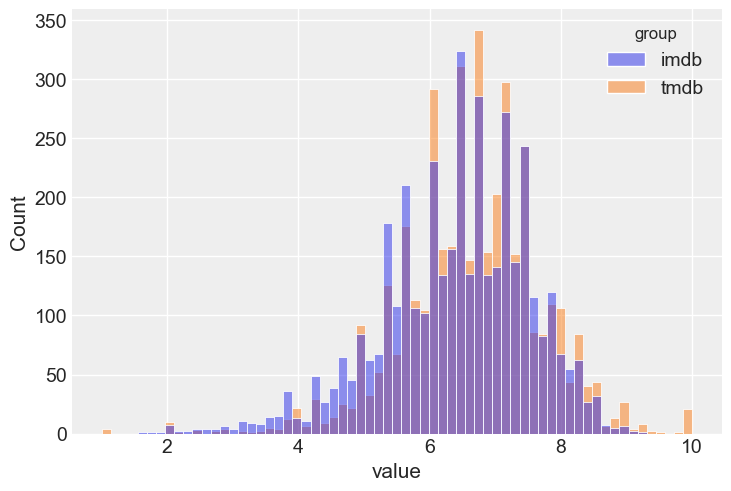

In [14]:
# Check the distribution of the two scores, from imdb and from tmbdb
y  = pd.DataFrame(dict(value=np.r_[netflix['imdb_score'], netflix['tmdb_score']], 
                       group=np.r_[['imdb']*len(netflix['imdb_score']), ['tmdb']*len(netflix['tmdb_score'])]))

sns.histplot(data=y, x="value", hue="group");

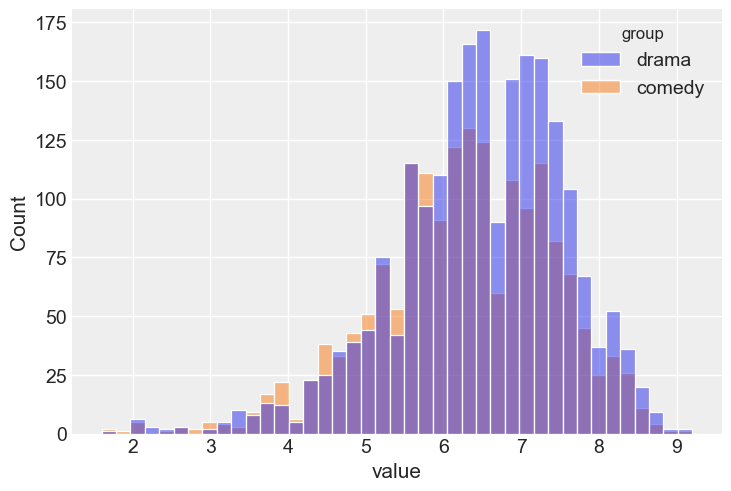

In [47]:
# Check the distribution of the two scores, from imdb and from tmbdb
# y  = pd.DataFrame(dict(value=np.r_[drama['imdb_score'], comedy['imdb_score']], 
#                        group=np.r_[['drama']*len(drama['imdb_score']), ['comedy']*len(comedy['imdb_score'])]))

# sns.histplot(data=y, x="value", hue="group");

### Research question

Possible question 1: is the hypothesis of equal means of the two populations plausible?

Possible question 2:

* We will fit a normal-normal model on each group.


* Then we will study the posterior distribution of the difference ($\mu_1 - \mu_2$)


* Recall the normal-normal model:
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu}) \\
\sigma &  \sim \text{half-normal}(\xi) \\
y & \sim N(\mu, \sigma) \\
\end{align*}

In [15]:
# Compute the mean score and standard deviation for imdb and tmdb
netflix_describe = netflix.describe()

# Mean scores
imdb_mean = netflix_describe['imdb_score'].loc['mean']
tmdb_mean = netflix_describe['tmdb_score'].loc['mean']
print("imdb mean score:", imdb_mean)
print("tmdb mean score:", tmdb_mean)
scores_mean = (imdb_mean + tmdb_mean)/2
print('mean score:', scores_mean)

# Standard deviations
imdb_std = netflix_describe['imdb_score'].loc['std']
tmdb_std = netflix_describe['tmdb_score'].loc['std']
print("\nimdb std:", imdb_std)
print("tmdb std:", tmdb_std)
std_mean = (imdb_std + tmdb_std)/2
print('mean std:', std_mean)

imdb mean score: 6.389899485167937
tmdb mean score: 6.622134346653581
mean score: 6.5060169159107595

imdb std: 1.1332380635930401
tmdb std: 1.0673718042503184
mean std: 1.1003049339216793


### Background information to set the prior

* The mean of the scores is about 6.5.
* The score of movies and tv shows follow a normal distribution, its mean can be assumed to be in (4.5, 8.5).
* Extreme values for the score are 1 (very poorly-made film) and 10 (masterpiece film). A plausible value for the standard deviation in the population is thus (6.5-1)/2 = 2.75.

### Prior for $\mu_{\text{imdb}}$ and $\mu_{\text{tmdb}}$

* The mean score of the population lies in (4.5, 8.5);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{imdb}}   \sim  N (6.5, 1.375)
$$
$$
\mu_{\text{tmdb}}   \sim  N (6.5, 1.375)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.

In [24]:
#Here we tune the half-normal prior for sigma, adjusting the scale to have the median close to 2.5.

# this yields a  diffuse prior, but still defined over plausible range. 
pd.DataFrame(halfnorm.rvs(scale=2.7, size=10000)).describe()

,0
count,10000.000000
mean,2.140794
std,1.620262
min,0.000529
25%,0.860624
50%,1.807708
75%,3.078712
max,10.190107


### Likelihood


* Assuming a Gaussian distribution of the observations,  we have:

$$\vec{y}_{imdb} \sim N(\mu_{\text{imdb}}, \sigma_{\text{imdb}})$$

$$\vec{y}_{tmdb} \sim N(\mu_{\text{tmdb}}, \sigma_{\text{tmdb}})$$

where we use the vector notation to make it clear that these are array of measures.

###  The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).

\begin{align*}
\mu_{\text{imdb}} & \sim N(6.5,1.133) \\
\sigma_{\text{imdb}} & \sim \text{half-normal} (2.7) \\
\vec{y}_{\text{imdb}}  & \sim N(\mu_{\text{imdb}}, \sigma_{\text{imdb}}) \\
\\
\mu_{\text{tmdb}} & \sim N(6.5,1.067) \\
\sigma_{\text{tmdb}} & \sim \text{half-normal} (2.7) \\
\vec{y}_{\text{tmdb}}  & \sim N(\mu_{\text{tmdb}}, \sigma_{\text{tmdb}})\\
\end{align*}


### Comparing two means $\mu_1$ and $\mu_2$

We consider  the difference between the means of the populations:
$$\mu_1 - \mu_2$$ 

* We  can define it as a *deterministic* variables in PyMC3, as it is a deterministic function of two parameters.


* We will have the posterior samples of ($\mu_1 - \mu_2$) in the trace.

In [25]:
# with pm.Model() as normal_model:
#     #prior
#     mu_imdb = pm.Normal('mu_imdb', mu = 6.5, sd = 1.133)
#     mu_tmdb = pm.Normal('mu_tmdb', mu = 6.5, sd = 1.067)
#     sigma_imdb = pm.HalfNormal('sigma_imdb', sigma=2.7)
#     sigma_tmdb = pm.HalfNormal('sigma_tmdb', sigma=2.7)

    
#     #likelihood of group 1
#     #y_imdb = pm.Normal('y_1', mu=mu_imdb, sigma=sigma_imdb, observed=netflix_describe['imdb_score'])
#     y_imdb = pm.Bound(pm.Normal, lower=1, upper=10)('y_1', mu=mu_imdb, sd=sigma_imdb, observed=netflix_describe['imdb_score'])
    
#     #likelihood of group 2
#     #y_tmdb = pm.Normal('y_2', mu=mu_tmdb, sigma=sigma_tmdb, observed=netflix_describe['tmdb_score'])
#     y_tmdb = pm.Bound(pm.Normal, lower=1, upper=10)('y_2', mu=mu_tmdb, sd=sigma_tmdb, observed=netflix_describe['tmdb_score'])
    
#     #The deterministic variables are function of the parameters, whose values appear in the trace.
#     diff_of_means = pm.Deterministic ('diff_of_means', mu_imdb - mu_tmdb)

ValueError: Observed Bound distributions are not supported. If you want to model truncated data you can use a pm.Potential in combination with the cumulative probability function.

In [26]:
with pm.Model() as normal_model:
    #prior
    mu_imdb = pm.Normal('mu_imdb', mu = imdb_mean, sd = imdb_std)
    mu_tmdb = pm.Normal('mu_tmdb', mu = tmdb_mean, sd = tmdb_std)
    sigma_imdb = pm.HalfNormal('sigma_imdb', sigma=2.7)
    sigma_tmdb = pm.HalfNormal('sigma_tmdb', sigma=2.7)

    
    #likelihood of group 1
    y_imdb = pm.Normal  ('y_1',  mu=mu_imdb,      sigma=sigma_imdb,       observed= netflix['imdb_score'])
    
    #likelihood of group 2
    y_tmdb = pm.Normal  ('y_2',  mu=mu_tmdb, sigma=sigma_tmdb, observed= netflix['tmdb_score'])
    
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_imdb - mu_tmdb)

In [27]:
with normal_model:
    normal_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_tmdb, sigma_imdb, mu_tmdb, mu_imdb]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


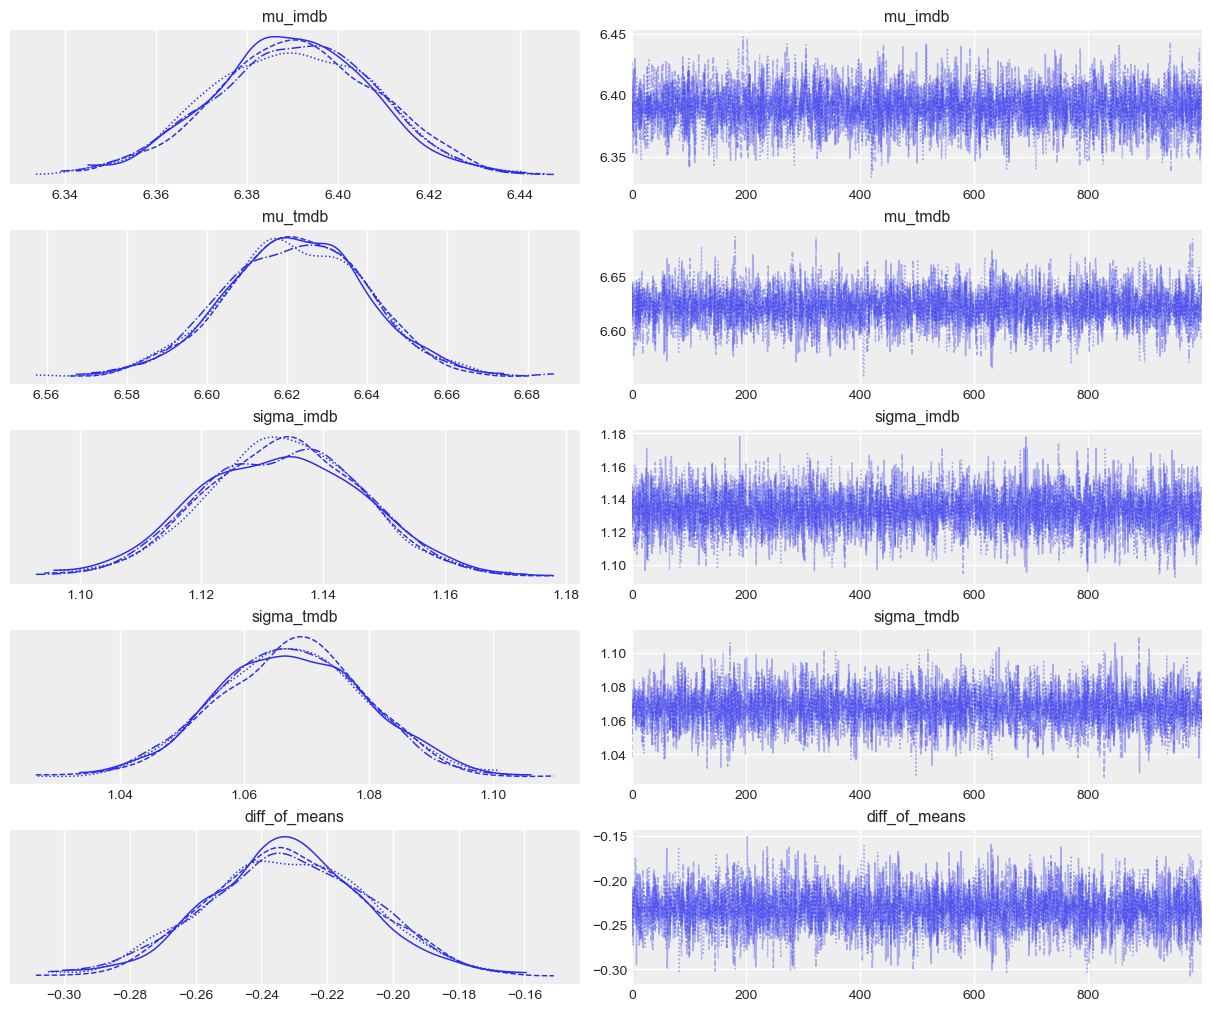

In [28]:
#sampling was good. The posterior of sigma is very similar for both groups, while there are differences in  the posterior mean of the two groups.
az.plot_trace(normal_trace);

In [29]:
# The posterior distribution can be checked in different ways, depending on the question we want to answer.

#Possible question 1: is the hypothesis of equal means of the two populations plausible?
#In traditional hypothesis testing, this corresponds to test the  hypothesis diff mu = 0.
#Formally the 0 is a plausible value (although at the very limit of the 95% HDI) 
az.summary(normal_trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_imdb,6.390,0.018,6.357,6.426,0.0,0.0,5458.0,2848.0,1.0
mu_tmdb,6.622,0.017,6.587,6.656,0.0,0.0,5787.0,3006.0,1.0
sigma_imdb,1.133,0.013,1.109,1.160,0.0,0.0,5752.0,3253.0,1.0
sigma_tmdb,1.068,0.012,1.044,1.090,0.0,0.0,5369.0,3321.0,1.0
diff_of_means,-0.232,0.024,-0.279,-0.184,0.0,0.0,5499.0,2711.0,1.0


Here our difference of means is 0.232, so we can say that the two means are practically equal.

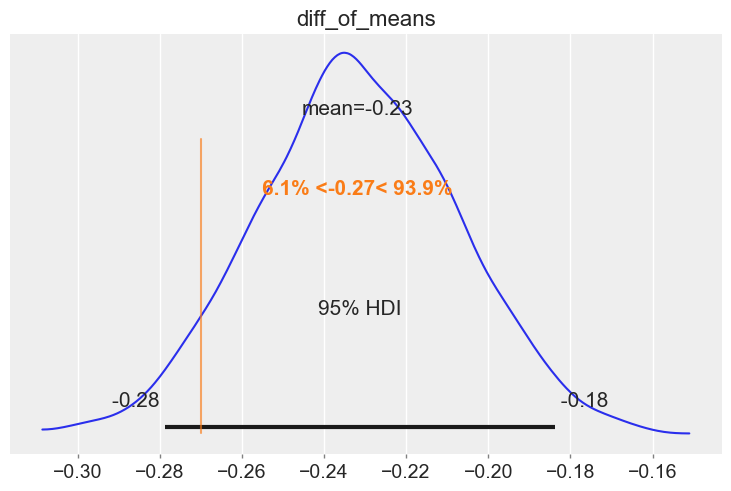

In [31]:
# Possible question 2: which is the posterior probability of an higher score in imdb scoreboard?

#There is a probability >95% of tmdb giving an higher score than imdb; thus we accept the hypothesis oftmdb giving higher scores.
az.plot_posterior(normal_trace,  var_names="diff_of_means", ref_val=-0.27, hdi_prob=0.95);

# Hierarchical model

In [19]:
director_mean_score=netflix.groupby(['director']).mean().sort_values('imdb_score')
director_mean_score=director_mean_score['imdb_score']
director_mean_score.describe()

count    3111.000000
mean        6.363342
std         1.099127
min         1.600000
25%         5.700000
50%         6.500000
75%         7.150000
max         9.100000
Name: imdb_score, dtype: float64

In [20]:
# Number of the songs of each artists; it varies between 2 and 40.
director_count=netflix.groupby(['director']).count().sort_values('title')
director_count=director_count['title']
director_count

director
Krishna D.K.           1
Monique Gardenberg     1
Monty Tiwa             1
Mor Loushy             1
Morgan Pehme           1
                      ..
Marcus Raboy          14
Jay Karas             15
Ryan Polito           17
Jan Suter             19
Raúl Campos           20
Name: title, Length: 3111, dtype: int64

# Prior on $\mu$

* A priori,  we assume $\mu$ to lie in  (5.5, 7,5).

* Interpreting the  interval as a region of $\pm$2 standard deviations, our prior beliefs about the mean of the population is:

$$ \mu \sim N(\underbrace{6.5}_{\mu'}, \underbrace{1}_{\sigma_{\mu}}) $$



# Prior on $\sigma$

In [22]:
# sigma controls the spread of popularity in the whole population of songs
# We can interpret the range (0, 10) as a range with length 4 stds (+-2 std around the mean).
# Thus a plausible value of  sigma is  2,5. 
#This is slightly in excess, as some density is outside the allowed range (0,10).

# Using  scale 3.8, we get the median of the distribution close to 2,5.
from scipy.stats import halfnorm 
pd.DataFrame(halfnorm.rvs(scale=3.8, size=10000)).describe()

,0
count,10000.000000
mean,3.034543
std,2.277043
min,0.000150
25%,1.232239
50%,2.555311
75%,4.372679
max,13.384406


# Hierarchical model

\begin{equation}
\begin{array}{lrl}
& \hspace{-0.05in} y_{ij} \sim N( \mu_j, \sigma) & \hspace{-0.075in} \text{distrib of  popularity of the songs of artist } j \\
& \hspace{-0.05in} \sigma\sim HN(\xi) & \hspace{-0.075in} \text{prior on } \sigma  \\
 & \hspace{-0.05in} \mu_j \sim N( \mu', \sigma_\mu) & \hspace{-0.075in}  \text{ $\mu_j$ is a sample from the population of artists}\\
 & \hspace{-0.05in}  \mu' \sim N(\mu_{\text{pop}}, \sigma_{\mu}) &
 \text{prior beliefs about mean popularity in the population} \\
& \sigma_\mu  \sim HN(\xi_2)  & \hspace{-0.075in}
 \text{prior beliefs about std of populairity in the population} 
\\
\end{array}
\end{equation}

* There is a prior over $\mu'$ and $\sigma_{\mu}$ (which are instead fixed numbers in the normal-normal model). This is a *hierarchy* of priors.

# Individual songs for each artist.

* As in the unpooled model,  the popularity of songs  of  artist $j$ are distributed:

$$  y_{ij} \sim N(\mu_j, \sigma) $$


*  $σ$ is the global sigma, which is equal for  all artists.

* $\mu_j$ is however differently estimated by the unpooled and the hierarchical model; see later.

# Population of artists



* The 44 $\mu_j$'s  are samples  from the population of Spotify artists:


$$ \mu_j \sim N(\mu', \sigma_{\mu}) $$

* $\mu'$: mean of the $\mu_j$'s in the whole population of  Spotify artists 
* $\sigma_{\mu}$: spread between the  $\mu_j$'s within the population

# Modeling the population of artists

$$ \mu_j \sim N(\mu', \sigma_{\mu}) $$


* We want to learn the population of artists.
* Both $\mu'$ and $\sigma_{\mu}$ are  *parameters*, to which we will assign a prior.

# Notation alert

*  $\mu_j$: mean popularity of songs from  the j-th artist
* $\mu'$: mean value of the $\mu_j$'s within the whole  population of artists


* $\sigma$:  standard deviation of popularity between songs from the same author. 
* $\sigma_{\mu}$ standard deviation of the $\mu_j$ within the population of artists.

# Priors for  $\mu'$ and  $\sigma_{\mu}$

\begin{align*}
\mu'           & \sim N(50, 20) && \text{95% pred interval is (50 +- 40)} \\
\sigma_\mu & \sim \text{Half Normal}(6)    && \text{spread betweent the different mu_j : see next slide}  \\
\end{align*}

In [23]:
#names mapped into codes
netflix['director_code']  = netflix['director'].astype('category').cat.codes

In [24]:
n_artist = len(director_count) #44

with pm.Model() as hier_model:
    
    # prior on the parameters of the population of artists (hyper-priors). 
    
    # prior beliefs about the mean value and the spread of the different mu_j
    #This is where the hierarchical model differs from the unpooled model.
    mu_pop         = pm.Normal ('mu_pop', 5.5,  7.5)
    sigma_mu     = pm.HalfNormal ('sigma_mu', 3.8)
    
    
    # layer 2: each artist is a sample from the population of artists; we sample n_artist times from such population.
    mu_artist        =  pm.Normal ('mu_artist', mu=mu_pop, sigma=sigma_mu, shape= n_artist)
    
    # global_sigma (spread between songs of the same authors) is as in the unpooled model.
    global_sigma   =  pm.HalfNormal ('global_sigma', sd = 4)

    #Popularity of each song is a sample from N(mu_j, global_sigma).
    popularity    =  pm.Normal ('score', mu = mu_artist[netflix['director_code']],  sigma = global_sigma, observed = netflix["imdb_score"])
    
    trace_hier    = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, mu_artist, sigma_mu, mu_pop]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.7122591070741426, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [25]:
#mu_pop is indeed close to 50 as we assumed
#the 95% popularity of the artists varies in roughly 52 +- 30
#the songs of a given author are comprised with 95% probability within a range of +-28 around its mean.
az.summary(trace_hier, var_names=["mu_pop", "sigma_mu", "global_sigma", "mu_artist"])[["mean","hdi_3%","hdi_97%","r_hat"]].head()

,mean,hdi_3%,hdi_97%,r_hat
mu_pop,6.371,6.335,6.406,1.00
sigma_mu,0.761,0.710,0.808,1.01
global_sigma,0.843,0.808,0.877,1.01
mu_artist[0],6.138,5.224,7.079,1.00
mu_artist[1],5.565,4.569,6.627,1.00


In [26]:
trace_hier.posterior = trace_hier.posterior.assign_coords(mu_artist_dim_0=directors)

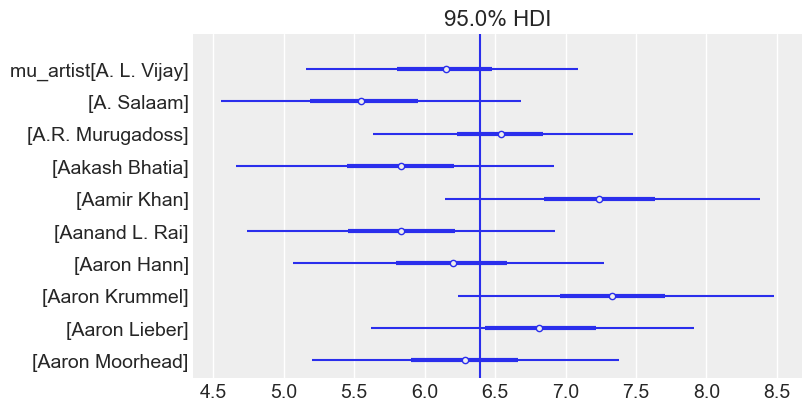

In [33]:
axes = az.plot_forest(trace_hier, combined=True,
                      var_names='mu_artist', hdi_prob=0.95, coords={"mu_artist_dim_0": directors[0:10]},  figsize=(8, 4));
#mean popularity of all songs
grand_mean = netflix["imdb_score"].mean()
axes[0].axvline(x=grand_mean);

In [28]:
# Make predictions
new_film_data = {'director': 'Director Name'}
new_film_df = pd.DataFrame(data=new_film_data, index=[0])

In [29]:
with model:
    a_pred = pm.sample_posterior_predictive(trace, vars=[a])['a']
    director_idx = netflix['director'].unique().tolist().index(new_film_df['director'].iloc[0])
    rating_pred = a_pred[:, director_idx]
    print(rating_pred.mean())

NameError: name 'model' is not defined

In [29]:
#prediction for a novel artist
post_hier                = az.extract_dataset(trace_hier.posterior)

#posterior parameters of the population
mu_population     = post_hier.mu_pop.values
sigma_population = post_hier.sigma_mu.values

mu_new_artist  = np.zeros(len(mu_population))

for i, current_mu in enumerate(mu_population):
        mu_new_artist[i] = np.random.normal (loc = mu_population[i], scale = sigma_population[i])

#now we have the distribution for the mean of the novel artist.
#we thus compute the distribution for its next song
global_sigma = post_hier.global_sigma.values
popularity_new_song_new_artist  = np.zeros(len(global_sigma))

for i, current_mu in enumerate(mu_population):
        popularity_new_song_new_artist[i] = np.random.normal (loc = mu_new_artist[i], scale = global_sigma[i])

#we obtain a  large predictive distribution, whose 95% hdi varies between 9.8 and 94.
#there is a major increase in the std wrt a known artist such as Beyonce.
pd.DataFrame(popularity_new_song_new_artist).describe(percentiles=[0.025, 0.975])        

,0
count,4000.000000
mean,52.089399
std,20.612853
min,-21.529096
2.5%,10.611366
50%,52.204925
97.5%,93.067593
max,133.227655


In [23]:
# predictive distribution for a measure taken in a new county.
# This is not possible with the unpooled model.
# Part 1 

post_hier    = az.extract_dataset(hier_trace.posterior)

# First, we create plausible value of intercepts by sampling from the population of intercepts 
mu_a = post_hier.mu_a.values
sigma_a = post_hier.sigma_a.values
alpha_new = np.zeros(len(mu_a))

#for i, current_mu in enumerate(mu_a):
 #   alpha_new[i] = np.random.normal (loc = mu_a[i], scale = sigma_a[i])

#vectorized implementation is more elegant, but equivalent to the loop above
alpha_new = np.random.normal (loc = mu_a, scale = sigma_a)

 #samples of the slope and of the sigma   
beta_hier =  post_hier.beta.values
sigma_y =  post_hier.sigma_y.values

In [24]:
# predictive distribution for a measure taken in a new county.
# Part 2 
        
#predictive distribution for a new measure in the new county
y_new = np.zeros(len(alpha_new))

for i, current_mu in enumerate(alpha_new):
        y_new[i] = np.random.normal (loc = alpha_new[i] + beta_hier[i] *  floor_0 , scale = sigma_y[i])

pd.DataFrame(y_new).describe()

,0
count,4000.000000
mean,1.285239
std,0.800339
min,-1.844501
25%,0.760300
50%,1.275225
75%,1.816677
max,4.360914


In [15]:
# the hierarchical model is ranked first
az.waic (pooled_trace)
az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace}, ic='waic')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
hierarchical,0,-1036.192592,48.672866,0.000000,9.297917e-01,27.907732,0.000000,True,log
unpooled,1,-1054.950330,79.920422,18.757738,1.210059e-15,28.370718,5.655189,True,log
pooled,2,-1090.062375,3.947581,53.869783,7.020827e-02,25.045747,10.690158,False,log


In [19]:
# we can also compare the models via WAIC

# the Student model is ranked first
az.compare({'gaussian':gaussian_trace, 'student': st_trace}, ic='waic')

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
student,0,11.242291,6.642480,0.000000,0.908646,28.685282,0.000000,True,log
gaussian,1,-21.743886,4.512721,32.986177,0.091354,5.434656,23.281027,True,log
